## Preparing environment

In [1]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.decomposition import TruncatedSVD
from category_encoders.cat_boost import CatBoostEncoder
from tqdm import tqdm
from catboost import CatBoostRegressor

import seaborn as sns
import matplotlib.pyplot as plt

data_path = "./data"

In [2]:
seed = 42

## Data processing

In [3]:
# reading data
data_dsc = pd.read_csv(os.path.join(data_path, "data_dsc.csv"))
data_dsc = data_dsc.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])
data_fp = pd.read_csv(os.path.join(data_path, "data_fp.csv"))
data_fp = data_fp.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])
data_2d = pd.read_csv(os.path.join(data_path, "data_2d.csv"))
data_2d = data_2d.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])

In [4]:
# deleting duplicate columns
data = pd.concat([data_dsc, data_fp, data_2d], axis=1)
data = data.loc[:, ~data.columns.duplicated()].copy()
data.shape

(36377, 2264)

In [5]:
X = data.drop(columns=["IC50"])
y = data["IC50"]

In [6]:
# deleting columns with 1 unique value
useless_columns = list()

for column in tqdm(X.columns):
    if X[column].unique().shape[0] == 1:
        useless_columns.append(column)

X = X.drop(columns=useless_columns)
len(useless_columns)

100%|██████████| 2263/2263 [00:00<00:00, 6970.21it/s]


7

In [7]:
need_to_fill_columns = list()

for column in X.columns:
    if X[column].isnull().any():
        need_to_fill_columns.append(column)

print(len(need_to_fill_columns))

12


In [8]:
# filling nans
imputer = SimpleImputer(strategy='mean')
X[need_to_fill_columns] = imputer.fit_transform(X[need_to_fill_columns])

### Feature engineering

In [9]:
X["TitleLen"] = X["Title"].apply(lambda x: len(x))
X["SMILESLen"] = X["SMILES"].apply(lambda x: len(x))

In [10]:
def get_first_number(s):
    number = str()
    flag = False
    for c in s:
        if c.isnumeric():
            number += c
            flag = True
        elif flag:
            break
    return int(number)

def get_first_str(s):
    first_str = str()
    flag = False
    for c in s:
        if c.isalpha():
            first_str += c
            flag = True
        elif flag:
            break
    return first_str

In [11]:
X["FirstNumTitle"] = X["Title"].apply(get_first_number)
# X["FirstStrTitle"] = X["Title"].apply(get_first_str)

### Last preparation

In [12]:
text_features = ["Title", "SMILES"]

In [13]:
cat_features = list()

for column, dtype in X.dtypes.to_dict().items():
    if column in text_features:
        continue
    elif dtype == "object":
        cat_features.append(column)
    elif X[column].dtype == int and X[column].unique().shape[0] < 10:
        cat_features.append(column)

len(cat_features)

2122

### Few graphs

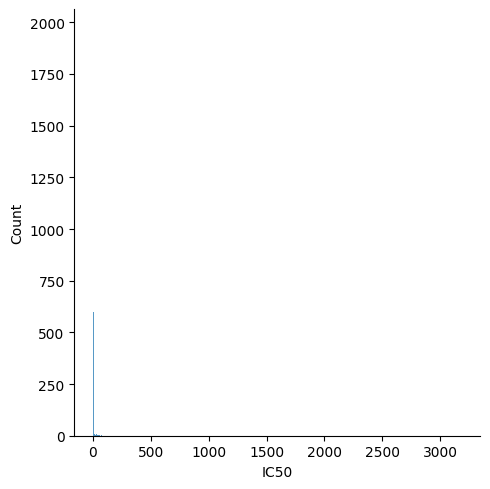

In [14]:
sns.displot(y)
plt.show()

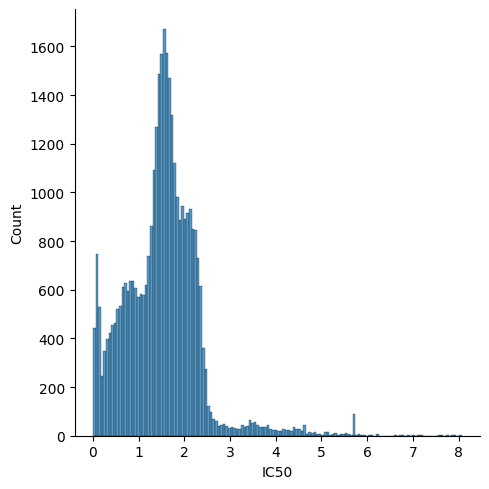

In [15]:
sns.displot(np.log1p(y))
plt.show()

In [16]:
# logarithm target
y = np.log1p(y)

## Models

### CatBoost

In [17]:
def title_catboost_processing(title):
    new_title = str()
    for s in title:
        if s.isdigit():
            new_title += f' {s}'
        else:
            new_title += s
    return new_title

In [18]:
X_copy = X.copy()
y_copy = y.copy()

# Processing text features
# Splitting numbers in title by spaces (to create  separate tokens)
X_copy["Title"] = X_copy["Title"].apply(title_catboost_processing)
X_copy["SMILES"] = X_copy["SMILES"].apply(lambda x: ' '.join(list(x)))

X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.2, random_state=seed)

In [19]:
cb_model = CatBoostRegressor(
    iterations=1500,
    text_features=text_features,
    cat_features=cat_features,
    eval_metric="R2",
    learning_rate=0.18,
    verbose=100,
    use_best_model=True,
    early_stopping_rounds=300,
)

cb_model.fit(X_train, y_train, eval_set=(X_val, y_val))

preds = cb_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

0:	learn: 0.0529471	test: 0.0529239	best: 0.0529239 (0)	total: 86.5ms	remaining: 2m 9s
100:	learn: 0.4261791	test: 0.3072824	best: 0.3073405 (99)	total: 5.12s	remaining: 1m 10s
200:	learn: 0.4985548	test: 0.3210178	best: 0.3211280 (198)	total: 10.2s	remaining: 1m 6s
300:	learn: 0.5487301	test: 0.3276013	best: 0.3278197 (298)	total: 15.5s	remaining: 1m 1s
400:	learn: 0.5855055	test: 0.3290729	best: 0.3290729 (400)	total: 20.7s	remaining: 56.8s
500:	learn: 0.6157673	test: 0.3322221	best: 0.3322221 (500)	total: 26s	remaining: 51.8s
600:	learn: 0.6436404	test: 0.3299065	best: 0.3323205 (506)	total: 31.3s	remaining: 46.9s
700:	learn: 0.6659777	test: 0.3322740	best: 0.3326228 (683)	total: 36.8s	remaining: 41.9s
800:	learn: 0.6893619	test: 0.3311811	best: 0.3326228 (683)	total: 42.3s	remaining: 36.9s
900:	learn: 0.7109825	test: 0.3320474	best: 0.3326228 (683)	total: 47.8s	remaining: 31.8s
1000:	learn: 0.7292631	test: 0.3323854	best: 0.3328780 (957)	total: 53.4s	remaining: 26.6s
1100:	learn: 0

0.12657950777752613

### CatBoost permutation importance

In [20]:
cb_importances_name = "cb_importances.json"

if not os.path.isfile(cb_importances_name):

    importance = permutation_importance(cb_model, X_val, y_val, scoring="r2", n_repeats=5, random_state=seed, n_jobs=-1)
    for k, v in importance.items():
        importance[k] = v.tolist()

    with open(cb_importances_name, "w") as fp:
        json.dump(importance, fp=fp)

In [21]:
with open(cb_importances_name, "r") as fp:
    importance = json.load(fp)

In [22]:
stay_cb_importance_columns = list()
drop_cb_importance_columns = list()

threshold = 1e-3

for i, v in enumerate(importance["importances_mean"]):
    if v > threshold:
        stay_cb_importance_columns.append(X_val.columns[i])
    else:
        drop_cb_importance_columns.append(X_val.columns[i])

print(len(stay_cb_importance_columns))

44


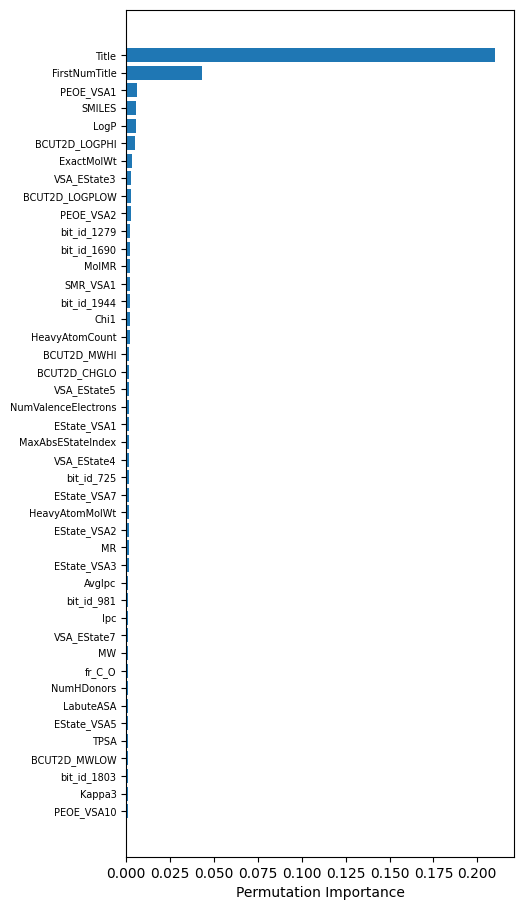

In [23]:
barh_dict = dict()

for i, v in enumerate(importance["importances_mean"]):
    if v > threshold:
        # print(f'Feature: {X_val.columns[i]}, Score: {v:.5f}')
        barh_dict[X_val.columns[i]] = v

barh_dict = {k: v for k, v in sorted(barh_dict.items(), key=lambda item: item[1])}

plt.figure(figsize=(5, 11))
plt.barh(barh_dict.keys(), barh_dict.values())
plt.yticks(fontsize=7)
plt.xlabel('Permutation Importance')
plt.show()

### CatBoost with PI

In [24]:
X_copy = X.copy()
y_copy = y.copy()
X_copy = X_copy[stay_cb_importance_columns]
X_copy["Title"] = X_copy["Title"].apply(title_catboost_processing)
X_copy["SMILES"] = X_copy["SMILES"].apply(lambda x: ' '.join(list(x)))

X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.2, random_state=seed)

In [25]:
cb_model = CatBoostRegressor(
    iterations=1500,
    text_features=[feature for feature in text_features if feature not in drop_cb_importance_columns],
    cat_features=[feature for feature in cat_features if feature not in drop_cb_importance_columns],
    eval_metric="R2",
    learning_rate=0.2,
    verbose=100,
    use_best_model=True,
    early_stopping_rounds=600,
)

cb_model.fit(X_train, y_train, eval_set=(X_val, y_val))

preds = cb_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

0:	learn: 0.0656065	test: 0.0679731	best: 0.0679731 (0)	total: 5.67ms	remaining: 8.5s
100:	learn: 0.4263388	test: 0.3160007	best: 0.3161251 (99)	total: 614ms	remaining: 8.51s
200:	learn: 0.4897471	test: 0.3244925	best: 0.3250260 (187)	total: 1.22s	remaining: 7.91s
300:	learn: 0.5371519	test: 0.3244191	best: 0.3250260 (187)	total: 1.83s	remaining: 7.31s
400:	learn: 0.5735273	test: 0.3256627	best: 0.3259908 (391)	total: 2.44s	remaining: 6.7s
500:	learn: 0.6062778	test: 0.3256159	best: 0.3260126 (407)	total: 3.07s	remaining: 6.13s
600:	learn: 0.6350152	test: 0.3263161	best: 0.3267334 (593)	total: 3.69s	remaining: 5.53s
700:	learn: 0.6622822	test: 0.3246734	best: 0.3268579 (634)	total: 4.32s	remaining: 4.92s
800:	learn: 0.6866214	test: 0.3239990	best: 0.3268579 (634)	total: 4.94s	remaining: 4.31s
900:	learn: 0.7092150	test: 0.3222624	best: 0.3268579 (634)	total: 5.55s	remaining: 3.69s
1000:	learn: 0.7279791	test: 0.3205037	best: 0.3268579 (634)	total: 6.17s	remaining: 3.08s
1100:	learn: 0.

0.1331607758006419

### CatBoost with PI & SVD

In [26]:
X_copy = X.copy()
y_copy = y.copy()
X_copy["Title"] = X_copy["Title"].apply(title_catboost_processing)
X_copy["SMILES"] = X_copy["SMILES"].apply(lambda x: ' '.join(list(x)))

X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.2, random_state=seed)

In [27]:
svd_n_components = 16
svd = TruncatedSVD(n_components=svd_n_components, algorithm="randomized", random_state=seed)
svd.fit(X_train[drop_cb_importance_columns])

train_emb = pd.DataFrame(svd.transform(X_train[drop_cb_importance_columns]), columns=[f"emb_{i}"for i in range(svd_n_components)], index=X_train.index)
X_train = pd.concat([X_train[stay_cb_importance_columns], train_emb], axis=1)

val_emb = pd.DataFrame(svd.transform(X_val[drop_cb_importance_columns]), columns=[f"emb_{i}"for i in range(svd_n_components)], index=X_val.index)
X_val = pd.concat([X_val[stay_cb_importance_columns], val_emb], axis=1)

In [28]:
cb_model = CatBoostRegressor(
    iterations=2000,
    text_features=[feature for feature in text_features if feature not in drop_cb_importance_columns],
    cat_features=[feature for feature in cat_features if feature not in drop_cb_importance_columns],
    eval_metric="R2",
    learning_rate=0.12,
    verbose=100,
    use_best_model=True,
    early_stopping_rounds=600,
)

cb_model.fit(X_train, y_train, eval_set=(X_val, y_val))

preds = cb_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

0:	learn: 0.0392860	test: 0.0390780	best: 0.0390780 (0)	total: 5.17ms	remaining: 10.3s
100:	learn: 0.3887793	test: 0.3085388	best: 0.3085388 (100)	total: 666ms	remaining: 12.5s
200:	learn: 0.4511796	test: 0.3233923	best: 0.3233923 (200)	total: 1.32s	remaining: 11.8s
300:	learn: 0.4939177	test: 0.3275925	best: 0.3279311 (272)	total: 1.98s	remaining: 11.2s
400:	learn: 0.5287999	test: 0.3306824	best: 0.3306824 (400)	total: 2.65s	remaining: 10.6s
500:	learn: 0.5580316	test: 0.3301905	best: 0.3311565 (437)	total: 3.34s	remaining: 10s
600:	learn: 0.5856102	test: 0.3309486	best: 0.3313147 (580)	total: 4.03s	remaining: 9.38s
700:	learn: 0.6086952	test: 0.3315550	best: 0.3316859 (693)	total: 4.7s	remaining: 8.71s
800:	learn: 0.6309925	test: 0.3316327	best: 0.3322108 (748)	total: 5.38s	remaining: 8.06s
900:	learn: 0.6516834	test: 0.3330562	best: 0.3335060 (894)	total: 6.07s	remaining: 7.4s
1000:	learn: 0.6716826	test: 0.3332213	best: 0.3336196 (956)	total: 6.78s	remaining: 6.76s
1100:	learn: 0.6

0.13430790291159544 0.12 16

### LinearRegression

In [29]:
X_copy = X.copy()
y_copy = y.copy()

X_copy = X_copy.drop(columns=text_features)
X_copy[cat_features] = X_copy[cat_features].astype(str)

X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.2, random_state=seed)

cb_encoder = CatBoostEncoder(random_state=seed)
X_train[cat_features] = cb_encoder.fit_transform(X_train[cat_features], y_train)
X_val[cat_features] = cb_encoder.transform(X_val[cat_features])

In [30]:
linreg_model = LinearRegression(n_jobs=-1)
linreg_model.fit(X_train, y_train)

preds = linreg_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

R2: -0.00736758865185605


### LinearRegression with PI

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_copy.drop(columns=drop_cb_importance_columns), y_copy, test_size=0.2, random_state=seed)

In [32]:
linreg_model = LinearRegression(n_jobs=-1)
linreg_model.fit(X_train, y_train)

preds = linreg_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

R2: -0.00736758865185605


### RandomForest

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.2, random_state=seed)

In [34]:
rf_model = RandomForestRegressor(n_estimators=96, random_state=seed, n_jobs=-1)

rf_model.fit(X_train, y_train)

preds = rf_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

R2: 0.11005864108076746


### RandomForest with PI

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_copy.drop(columns=drop_cb_importance_columns), y_copy, test_size=0.2, random_state=seed)

In [36]:
rf_model = RandomForestRegressor(n_estimators=96, random_state=seed, n_jobs=-1)

rf_model.fit(X_train, y_train)

preds = rf_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

R2: 0.10629531525067104


### ExtraTreesRegressor

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_copy, y_copy, test_size=0.2, random_state=seed)

In [38]:
et_model = ExtraTreesRegressor(n_estimators=48, random_state=seed, n_jobs=-1)

et_model.fit(X_train, y_train)

preds = et_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

R2: 0.09781962070036554


### ExtraTreesRegressor with PI

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_copy.drop(columns=drop_cb_importance_columns), y_copy, test_size=0.2, random_state=seed)

In [40]:
et_model = ExtraTreesRegressor(n_estimators=48, random_state=seed, n_jobs=-1)

et_model.fit(X_train, y_train)

preds = et_model.predict(X_val)

print(f"R2: {r2_score(np.expm1(y_val), np.expm1(preds))}")

R2: 0.0925587919928822
